# **Assignment 4 part 1 - Customer Churn Prediction**
This notebook focuses on processing and analyzing a dataset of a company's customers to predict whether a customer is likely to leave (churn) or stay. In this assignment, we will:

1.  **Preprocess and clean the data:** Handle duplicates, missing values, encode categorical features, and standardize numerical columns to prepare the data for analysis.
2.  **Construct and train a Neural Network:** Build a fully connected neural network optimized for predicting customer churn.
3.  **Evaluate performance:** Use metrics such as accuracy, precision, recall, and a confusion matrix to analyze the model's predictions and draw insights.

## **Step 1: Data cleaning and Preprocessing**
### **1.1: Load the Dataset**
We begin by loading the dataset and examing its structure and displaying the first few rows of the dataset to confirm successful loading.

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/Churn_Modelling.csv")

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Check the data types of the columns
print("\nData types of the columns:")
print(df.dtypes)

First few rows of the dataset:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         9

### **1.2: Check for Duplicates**
We remove duplicate rows to ensure that each customer record is unique.

In [2]:
# Check for duplicate rows
duplicates = df.duplicated().sum()

# Remove duplicates if any
df.drop_duplicates(inplace=True)

print(f"Number of duplicates removed: {duplicates}")

Number of duplicates removed: 0


### **1.3: Handle Missing Values**
Missing values in numerical columns are imputed using the column mean to avoid data loss.

In [3]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")

# Fill missing values in numerical columns with the column mean
df.fillna(df.mean(numeric_only=True), inplace=True)

# Verify that no missing values remain
print("Number of missing values after imputation:")
print(df.isnull().sum())


Missing values in each column:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64
Number of missing values after imputation:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


### **1.4: Descriptive Statistics**
Descriptive statistics help summarize the data and check for normality. We will compute the mean, standard deviation, minimum, and maximum for each numerical feature.

In [4]:
# Descriptive statistics to understand the distribution of the data
descriptive_stats = df.describe()
print(f"Descriptive statistics:\n{descriptive_stats}")


Descriptive statistics:
         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
m

### **1.5: Data Normality Analysis**
To better understand the distribution of the data, we visualize histograms for each feature.

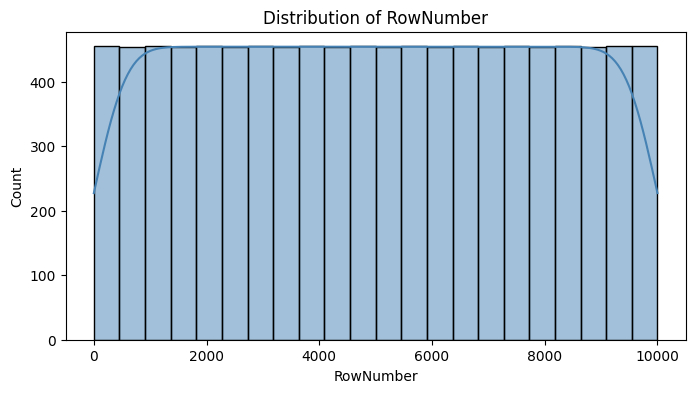

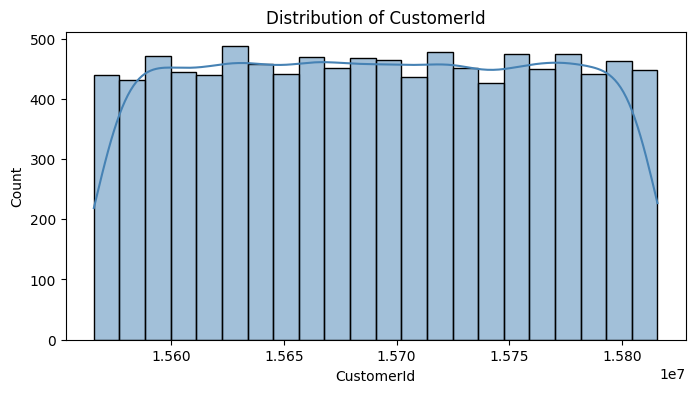

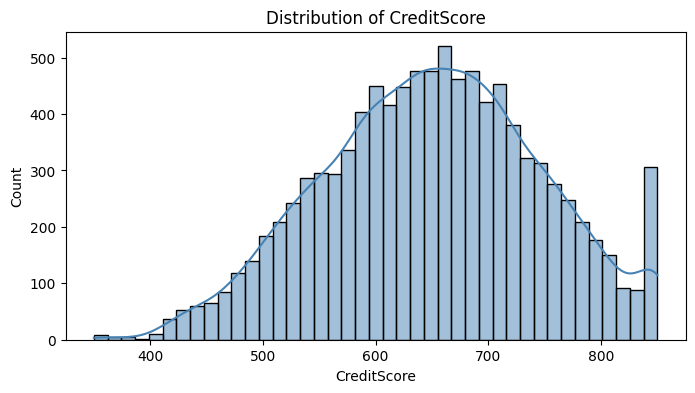

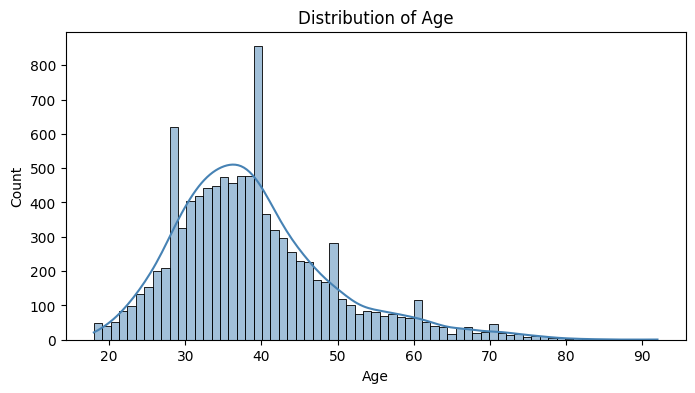

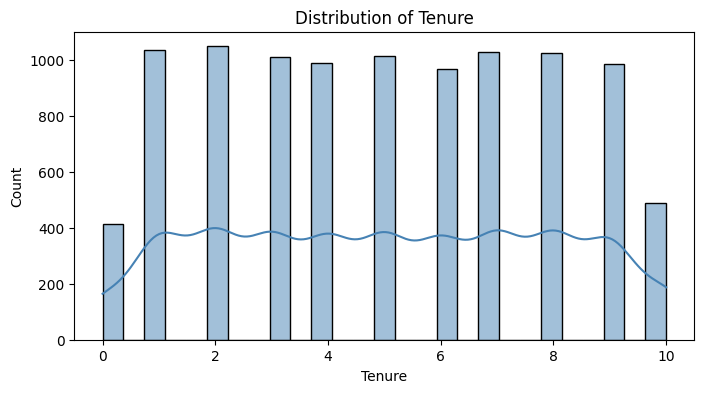

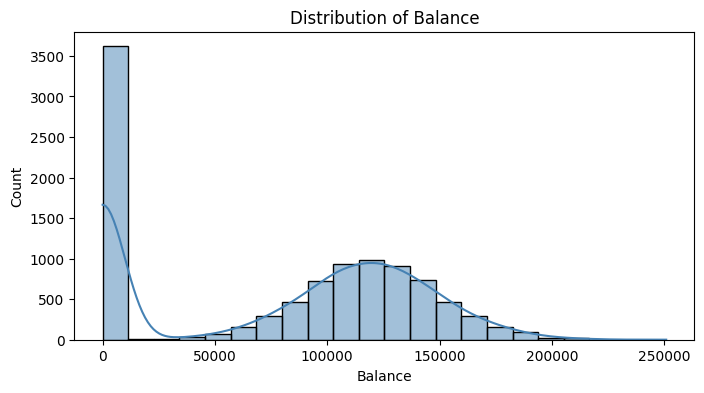

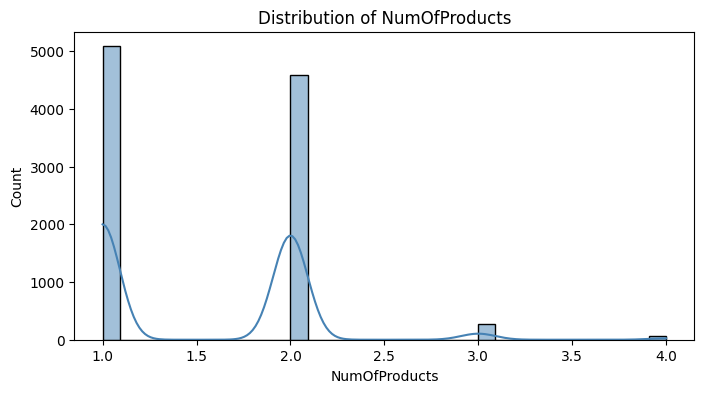

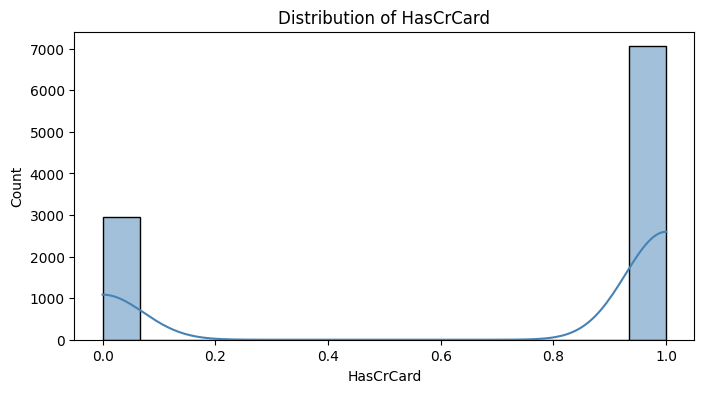

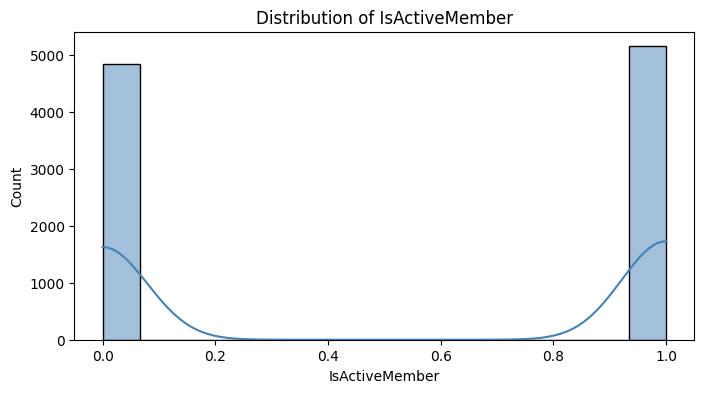

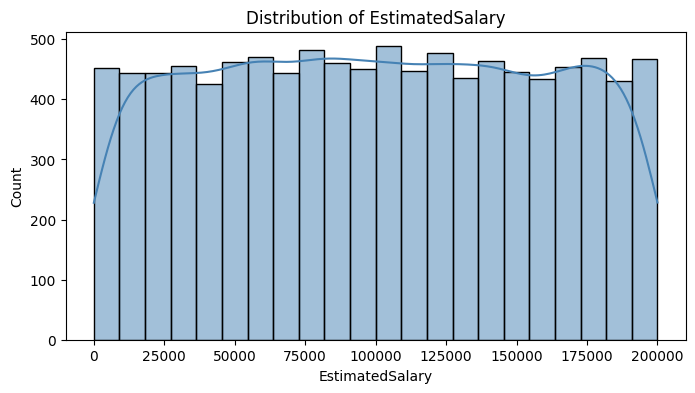

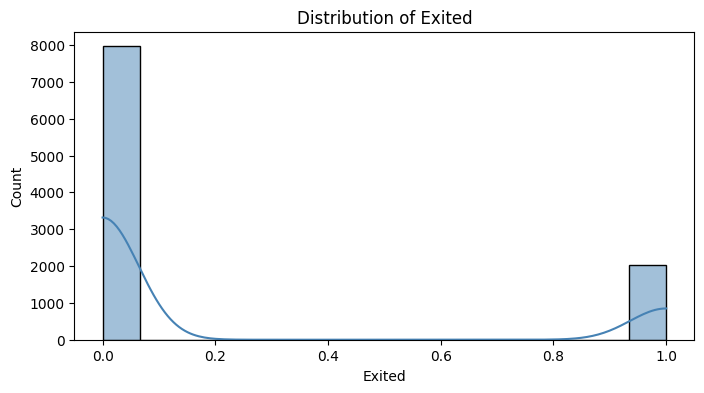

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for all numerical columns
df_numeric = df.select_dtypes(include=['int64', 'float64'])

# Plot the distribution for each numeric feature
for column in df_numeric.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True, color='steelblue')
    plt.title(f'Distribution of {column}')
    plt.show()


### **1.6: Drop Irrelevant Columns**
Columns like `RowNumber`, `CustomerId` and `Surname` are unique identifiers or names, which do not contribute to prediction. The dataset is reduced by removing superfluous columns.

In [6]:
# Dropping irrelevant columns
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
print(df.head())

   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  


### **1.7: Encode Categorical Variables**
Convert categorical variables like `Geography` and `Gender` into numeric formats. Label encoding converts binary categories into numerical format, and one-hot encoding creates binary columns for each unique value in multi-category fields. `Gender` is encoded as 0 and 1, and new columns `Geography_Germany` and `Geography_Spain` are added, representing the `Geography` variable.

In [7]:
from sklearn.preprocessing import LabelEncoder
# Encoding categorical variables
label_encoder_gender = LabelEncoder()
df['Gender'] = label_encoder_gender.fit_transform(df['Gender'])  # Male: 1, Female: 0

# One-hot encoding for Geography
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)
print(df.head())


   CreditScore  Gender  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619       0   42       2       0.00              1          1   
1          608       0   41       1   83807.86              1          0   
2          502       0   42       8  159660.80              3          1   
3          699       0   39       1       0.00              2          0   
4          850       0   43       2  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited  Geography_Germany  Geography_Spain  
0               1        101348.88       1              False            False  
1               1        112542.58       0              False             True  
2               0        113931.57       1              False            False  
3               0         93826.63       0              False            False  
4               1         79084.10       0              False             True  


### **1.8: Normalize Numerical Features**
Standardizing numerical features to improve neural network performance. Standardization ensures all features contribute equally by scaling them to a mean of 0 and standard deviation of 1.

In [8]:
from sklearn.preprocessing import StandardScaler

# Standardizing numerical features
scaler = StandardScaler()
features_to_scale = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])


### **1.9: Split the Dataset**
Splitting into training and testing sets helps evaluate model performance on unseen data, simulating real-world predictions. 80% of the data is used for training, and 20% is reserved for testing.

In [9]:
from sklearn.model_selection import train_test_split

# Splitting dataset into features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **Step 2: Construct and Train a Neural Network**
### **2.1: Build the Neural Network**
Neural networks consist of layers of neurons connected in a specific way. Fully connected (dense) layers are used for general prediction tasks. The network architecture is displayed.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Building the model
model = Sequential([
    Dense(16, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),  # Regularization
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 337 (1.32 KB)

 Trainable params: 337 (1.32 KB)

 Non-trainable params: 0 (0.00 B)

### **2.2: Train the Model**
Training optimizes the weights of the network using backpropagation to minimize the loss function.Training and validation metrics for each epoch are displayed.

In [11]:
# Training the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7309 - loss: 0.5633 - val_accuracy: 0.7994 - val_loss: 0.4392
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8007 - loss: 0.4552 - val_accuracy: 0.8181 - val_loss: 0.4134
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8028 - loss: 0.4419 - val_accuracy: 0.8288 - val_loss: 0.4002
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8197 - loss: 0.4280 - val_accuracy: 0.8381 - val_loss: 0.3892
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8259 - loss: 0.4103 - val_accuracy: 0.8363 - val_loss: 0.3839
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8367 - loss: 0.3914 - val_accuracy: 0.8406 - val_loss: 0.3771
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8292 - loss: 0.3971 - val_accuracy: 0.8388 - val_loss: 0.3721
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8301 - loss: 0.4044 - val_accuracy: 0.

## **Step 3: Performance Measures and Analysis**
### **3.1: Evaluate the Model**
Testing on unseen data provides an unbiased estimate of model performance.  The test loss and accuracy are reported.

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Test Loss: 0.3439706861972809, Test Accuracy: 0.859000027179718


### **3.2: Classification Report**
Metrics like precision, recall, and F1-score provide deeper insights into model performance, especially in imbalanced datasets.

In [13]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Generate classification report
print(classification_report(y_test, y_pred))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1607
           1       0.74      0.44      0.55       393

    accuracy                           0.86      2000
   macro avg       0.81      0.70      0.73      2000
weighted avg       0.85      0.86      0.84      2000



### **Step 3.3: Analyze Results**
Visualizing training history helps identify issues like overfitting or underfitting.

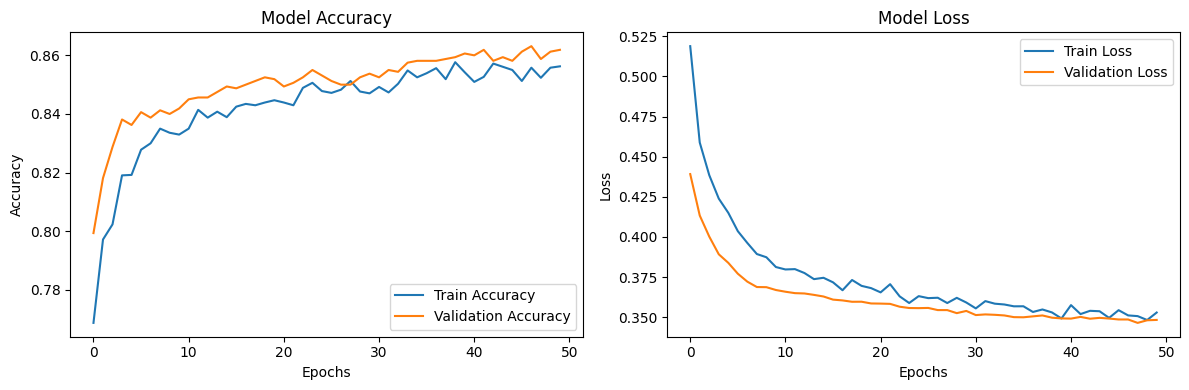

In [14]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
